In [1]:
import os
import glob
import pandas as pd

def find_mismatch_sequences(root_dir, verbose=True):
    records = []

    actions = [a for a in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, a))]
    if len(actions) == 0:
        print("Không tìm thấy action folder nào.")
        return pd.DataFrame()

    for action in actions:
        img_root = os.path.join(root_dir, action, "images_resized")
        kp_root  = os.path.join(root_dir, action, "keypoints")

        if not os.path.isdir(img_root) or not os.path.isdir(kp_root):
            continue

        seqs = [s for s in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, s))]
        for seq in seqs:
            img_dir = os.path.join(img_root, seq)
            kp_dir  = os.path.join(kp_root, seq)

            imgs = sorted(glob.glob(os.path.join(img_dir, "*.jpg"))) + sorted(glob.glob(os.path.join(img_dir, "*.png")))
            kps  = sorted(glob.glob(os.path.join(kp_dir, "*.json"))) if os.path.isdir(kp_dir) else []

            n_img, n_kp = len(imgs), len(kps)
            diff = abs(n_img - n_kp)
            records.append([action, seq, n_img, n_kp, diff])

    df = pd.DataFrame(records, columns=["action", "sequence", "n_images", "n_keypoints", "diff"])
    bad_df = df[df["diff"] > 0].reset_index(drop=True)

    if verbose:
        print(f" Tổng sequence kiểm tra: {len(df)}")
        print(f" Phát hiện {len(bad_df)} sequence lệch số lượng ảnh/keypoint\n")
        if len(bad_df) > 0:
            display(bad_df.head(20))
        else:
            print("Tất cả sequence đều khớp số lượng.")

    return bad_df

In [2]:
ROOT_DIR = "/kaggle/input/2811-002data/data_estiomation"

mismatch_df = find_mismatch_sequences(ROOT_DIR)
mismatch_df.to_csv("/kaggle/working/mismatch_sequences.csv", index=False)

 Tổng sequence kiểm tra: 644
 Phát hiện 0 sequence lệch số lượng ảnh/keypoint

Tất cả sequence đều khớp số lượng.


In [3]:
import os, shutil
from tqdm import tqdm

def copy_clean_sequences(root_dir, dest_dir, bad_df):
    os.makedirs(dest_dir, exist_ok=True)
    bad_pairs = set((a, s) for a, s in zip(bad_df["action"], bad_df["sequence"]))
    actions = [a for a in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, a))]
    for action in actions:
        img_src = os.path.join(root_dir, action, "images_resized")
        kp_src  = os.path.join(root_dir, action, "keypoints")
        img_dst = os.path.join(dest_dir, action, "images_resized")
        kp_dst  = os.path.join(dest_dir, action, "keypoints")
        os.makedirs(img_dst, exist_ok=True)
        os.makedirs(kp_dst,  exist_ok=True)
        seqs = [s for s in os.listdir(img_src) if os.path.isdir(os.path.join(img_src, s))]
        
        for seq in tqdm(seqs, desc=f"Copy {action}"):
            
            if (action, seq) in bad_pairs:
                continue  
            src_img_dir = os.path.join(img_src, seq)
            src_kp_dir  = os.path.join(kp_src, seq)
            dst_img_dir = os.path.join(img_dst, seq)
            dst_kp_dir  = os.path.join(kp_dst, seq)
            shutil.copytree(src_img_dir, dst_img_dir)
            
            if os.path.isdir(src_kp_dir):
                shutil.copytree(src_kp_dir, dst_kp_dir)

    print(f"Đã tạo dataset sạch tại: {dest_dir}")

In [4]:
clean_root = "/kaggle/working/data_estiomation"
copy_clean_sequences(
    root_dir="/kaggle/input/2811-002data/data_estiomation",
    dest_dir=clean_root,
    bad_df=mismatch_df
)

Copy FALL: 100%|██████████| 144/144 [00:27<00:00,  5.22it/s]

Đã tạo dataset sạch tại: /kaggle/working/data_estiomation


In [5]:
ROOT_DIR      = "/kaggle/working/data_estiomation" 

In [6]:

import os, glob, json, math, random, time, shutil
from typing import List, Tuple, Literal, Optional
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

ROOT_DIR   = "/kaggle/working/data_estiomation"  
ACTIONS    = ['CLIMB','FALL','LIEDOWN','SIT','STAND']
SEQ_LEN    = 12
IMG_SIZE   = 224
BATCH_SIZE = 12
LR         = 1e-4
SEED       = 42

AUTOTUNE = tf.data.AUTOTUNE
rng_np   = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("ROOT_DIR:", ROOT_DIR)
print("ACTIONS:", ACTIONS)


2025-12-02 12:19:09.309018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764677949.595138      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764677949.677154      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

ROOT_DIR: /kaggle/working/data_estiomation
ACTIONS: ['CLIMB', 'FALL', 'LIEDOWN', 'SIT', 'STAND']


In [7]:
def check_dataset_structure(root_dir: str):   
    print(f"Kiểm tra thư mục gốc: {root_dir}\n")

    if not os.path.isdir(root_dir):
        print(" Không tìm thấy thư mục gốc!")
        return False

    actions = [a for a in sorted(os.listdir(root_dir)) 
               if os.path.isdir(os.path.join(root_dir, a))]
    if len(actions) == 0:
        print(" Không có action folder nào trong thư mục gốc.")
        return False
    print(f"Phát hiện {len(actions)} action folders: {actions}\n")

    total_seq_all = 0
    total_img_all = 0
    total_kp_all  = 0
    for action in actions:
        act_path = os.path.join(root_dir, action)
        img_root = os.path.join(act_path, "images_resized")
        kp_root  = os.path.join(act_path, "keypoints")

        if not os.path.isdir(img_root):
            print(f" {action}: thiếu 'images_resized'")
            continue
        if not os.path.isdir(kp_root):
            print(f" {action}: thiếu 'keypoints'")
            continue

        seqs = [s for s in os.listdir(img_root)
                if os.path.isdir(os.path.join(img_root, s))]
        total_seq_all += len(seqs)
        print(f" {action}: {len(seqs)} sequences")

        total_img = 0
        total_kp  = 0
        mismatched = 0

        for seq in seqs:
            img_dir = os.path.join(img_root, seq)
            kp_dir  = os.path.join(kp_root,  seq)

            imgs = glob.glob(os.path.join(img_dir, "*.jpg")) \
                 + glob.glob(os.path.join(img_dir, "*.png"))
            kps  = glob.glob(os.path.join(kp_dir,  "*.json"))

            total_img += len(imgs)
            total_kp  += len(kps)
            if len(imgs) != len(kps):
                mismatched += 1

        total_img_all += total_img
        total_kp_all  += total_kp

        print(f"   ├─ Tổng ảnh     : {total_img:5d}")
        print(f"   ├─ Tổng keypoints: {total_kp:5d}")
        print(f"   └─ Trung bình   : {total_img/max(1,len(seqs)):.1f} ảnh/seq, "
              f"{total_kp/max(1,len(seqs)):.1f} kp/seq")
        if mismatched > 0:
            print(f"    {mismatched} sequences không khớp số ảnh/kp.")
        print()

    print(" Tổng hợp toàn bộ dataset:")
    print(f"   ├─ Tổng action  : {len(actions)}")
    print(f"   ├─ Tổng sequence: {total_seq_all}")
    print(f"   ├─ Tổng ảnh     : {total_img_all}")
    print(f"   └─ Tổng keypoints: {total_kp_all}")
    print("\n Hoàn tất kiểm tra cấu trúc dataset.")
    return True

In [8]:
from typing import List, Optional, Literal, Tuple
import os
import glob
import json
import cv2
import numpy as np

def uniform_indices(n: int, T: int = SEQ_LEN) -> List[int]:
    if n <= 0:
        return []
    if n == T:
        return list(range(n))
    if n > T:
        return [int(round(i * (n - 1) / (T - 1))) for i in range(T)]
    return list(range(n))

def random_window_uniform_indices(
    n: int,
    T: int = SEQ_LEN,
    window_ratio: float = 0.85,
    rng: Optional[np.random.Generator] = None
) -> List[int]:
    if n <= 0:
        return []
    if n <= T:
        return list(range(n))

    if rng is None:
        rng = np.random.default_rng()

    W = max(T, int(round(window_ratio * n)))
    W = min(W, n)

    start_max = n - W
    start = int(rng.integers(0, start_max + 1)) if start_max > 0 else 0
    end = start + W - 1

    return [int(round(start + i * (W - 1) / (T - 1))) for i in range(T)]


def pad_indices(
    n: int,
    T: int = SEQ_LEN,
    mode: Literal["replicate", "loop"] = "replicate",
    loop_tail: int = 2
) -> List[int]:
    idx = list(range(n))
    if n == 0:
        return [0] * T
    if n >= T:
        return idx[:T]
    if mode == "replicate":
        idx += [n - 1] * (T - n)
    else:
        tail = list(range(max(0, n - loop_tail), n)) or [n - 1]
        while len(idx) < T:
            idx += tail
        idx = idx[:T]

    return idx


def ffill_bfill_kps(kps: np.ndarray) -> np.ndarray:
    if kps.size == 0:
        return kps

    T = kps.shape[0]
    valid = np.any(kps != 0, axis=1)

    if not valid[0] and np.any(valid):
        first = np.argmax(valid)
        kps[:first] = kps[first]

    last = kps[0].copy()
    for t in range(T):
        if np.any(kps[t] != 0):
            last = kps[t]
        else:
            kps[t] = last

    return kps


def read_seq_paths(img_dir: str, kp_dir: str) -> Tuple[List[str], List[str]]:
    imgs = sorted(
        glob.glob(os.path.join(img_dir, "*.jpg"))
        + glob.glob(os.path.join(img_dir, "*.png"))
    )
    kps = sorted(glob.glob(os.path.join(kp_dir, "*.json")))

    n = min(len(imgs), len(kps))
    return imgs[:n], kps[:n]


def load_seq_24(
    img_paths: List[str],
    kp_paths: List[str],
    img_size: int = IMG_SIZE,
    mode: Literal["train", "val", "test"] = "train",
    window_ratio: float = 0.85,
    pad_mode: Literal["replicate", "loop"] = "replicate",
    loop_tail: int = 2,
    rng: Optional[np.random.Generator] = rng_np
) -> Tuple[np.ndarray, np.ndarray]:

    if len(img_paths) == 0 or len(kp_paths) == 0:
        return (
            np.zeros((SEQ_LEN, img_size, img_size, 3), np.float32),
            np.zeros((SEQ_LEN, 75), np.float32),
        )

    first = cv2.imread(img_paths[0])
    if first is None:
        return (
            np.zeros((SEQ_LEN, img_size, img_size, 3), np.float32),
            np.zeros((SEQ_LEN, 75), np.float32),
        )

    H, W = first.shape[:2]

    n = min(len(img_paths), len(kp_paths))
    img_paths = img_paths[:n]
    kp_paths = kp_paths[:n]

    if n > SEQ_LEN:
        sel = uniform_indices(n, SEQ_LEN)
    else:
        sel = list(range(n))

    frames, keyps = [], []

    for i in sel:
        im = cv2.imread(img_paths[i])
        if im is None:
            im = first.copy()

        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (img_size, img_size))
        frames.append(im.astype(np.float32) / 255.0)

        with open(kp_paths[i], "r") as f:
            jd = json.load(f)

        if "people" in jd and jd["people"] and "pose_keypoints_2d" in jd["people"][0]:
            arr = np.array(
                jd["people"][0]["pose_keypoints_2d"],
                dtype=np.float32
            ).reshape(-1, 3)
        else:
            arr = np.zeros((25, 3), dtype=np.float32)

        if W > 0 and H > 0:
            arr[:, 0] /= float(W)
            arr[:, 1] /= float(H)

        keyps.append(arr.reshape(-1))  

    frames = np.stack(frames, axis=0)  
    keyps = np.stack(keyps, axis=0) 
    m = frames.shape[0]

    if m < SEQ_LEN:
        pidx = pad_indices(m, SEQ_LEN, mode=pad_mode, loop_tail=loop_tail)
        frames = frames[pidx[:SEQ_LEN]]
        keyps = keyps[pidx[:SEQ_LEN]]

    keyps = ffill_bfill_kps(keyps)

    frames = frames[:SEQ_LEN]
    keyps = keyps[:SEQ_LEN]

    return frames.astype(np.float32), keyps.astype(np.float32)

print("Sampling & padding utils ready.")


Sampling & padding utils ready.


In [9]:
def list_sequences(root_dir: str, actions: List[str]) -> List[Tuple[str,str,str]]:  
    items = []
    for act in actions:
        img_root = os.path.join(root_dir, act, "images_resized")
        kp_root  = os.path.join(root_dir, act, "keypoints")
        if not (os.path.isdir(img_root) and os.path.isdir(kp_root)):
            continue

        for seq in sorted(os.listdir(img_root)):
            img_dir = os.path.join(img_root, seq)
            kp_dir  = os.path.join(kp_root, seq)
            if os.path.isdir(img_dir) and os.path.isdir(kp_dir):
                imgs = glob.glob(os.path.join(img_dir, "*.jpg")) \
                     + glob.glob(os.path.join(img_dir, "*.png"))
                kps  = glob.glob(os.path.join(kp_dir,  "*.json"))
                # ít nhất phải có 1 frame + 1 kp
                if len(imgs) == 0 or len(kps) == 0:
                    continue
                items.append((act, img_dir, kp_dir))
    return items


def split_items(items, train_ratio=0.7, val_ratio=0.15, seed=SEED):
  
    rng = np.random.default_rng(seed)
    items = items.copy()
    rng.shuffle(items)
    n = len(items)
    tr = int(train_ratio * n)
    va = int((train_ratio + val_ratio) * n)
    return items[:tr], items[tr:va], items[va:]


class2idx = {a: i for i, a in enumerate(ACTIONS)}


def seq_gen(items, mode="train"):
 
    for act, img_dir, kp_dir in items:
        img_paths, kp_paths = read_seq_paths(img_dir, kp_dir)

        frames, kps = load_seq_24(  
            img_paths, kp_paths,
            img_size=IMG_SIZE,
            mode=mode,
            window_ratio=0.85,
            pad_mode="replicate",
            loop_tail=2,
            rng=rng_np,
        )     
        if np.all(kps == 0):
            continue
        y = to_categorical(class2idx[act], num_classes=len(ACTIONS)).astype(np.float32)
        yield {"images": frames, "keypoints": kps}, y

output_signature = (
    {
        "images":    tf.TensorSpec(shape=(SEQ_LEN, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        "keypoints": tf.TensorSpec(shape=(SEQ_LEN, 75), dtype=tf.float32),
    },
    tf.TensorSpec(shape=(len(ACTIONS),), dtype=tf.float32),
)

def make_fusion_ds(items, mode="train", batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_generator(
        lambda: seq_gen(items, mode=mode),
        output_signature=output_signature
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=min(2048, len(items)*2), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=False).prefetch(AUTOTUNE)
    return ds

all_items = list_sequences(ROOT_DIR, ACTIONS)
train_items, val_items, test_items = split_items(all_items, 0.7, 0.15, SEED)

train_fusion_ds = make_fusion_ds(train_items, mode="train", shuffle=True)
val_fusion_ds   = make_fusion_ds(val_items,   mode="val",   shuffle=False)
test_fusion_ds  = make_fusion_ds(test_items,  mode="test",  shuffle=False)

print(f"Sequences -> train: {len(train_items)} | val: {len(val_items)} | test: {len(test_items)}")
print("Batches   -> train:", sum(1 for _ in train_fusion_ds),
      "| val:",   sum(1 for _ in val_fusion_ds),
      "| test:",  sum(1 for _ in test_fusion_ds))

xb, yb = next(iter(train_fusion_ds))
print("✅ Sanity batch shapes:")
print("   images   :", xb["images"].shape)
print("   keypoints:", xb["keypoints"].shape)
print("   labels   :", yb.shape)

train_labels = [class2idx[a] for a, _, _ in train_items]
cnt = Counter(train_labels)
print("Class distribution (train):", {ACTIONS[k]: v for k, v in cnt.items()})


2025-12-02 12:19:29.636652: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Sequences -> train: 450 | val: 97 | test: 97
Batches   -> train: 38 | val: 9 | test: 9
✅ Sanity batch shapes:
   images   : (12, 12, 224, 224, 3)
   keypoints: (12, 12, 75)
   labels   : (12, 5)
Class distribution (train): {'STAND': 135, 'LIEDOWN': 72, 'SIT': 89, 'FALL': 108, 'CLIMB': 46}


In [10]:
def make_kp_ds(base_ds):
    return base_ds.map(
        lambda x, y: (x["keypoints"], y),
        num_parallel_calls=AUTOTUNE,
    )
    
train_kp_ds = make_kp_ds(train_fusion_ds)
val_kp_ds   = make_kp_ds(val_fusion_ds)
test_kp_ds  = make_kp_ds(test_fusion_ds)

train_kp_ds = train_kp_ds.cache().prefetch(AUTOTUNE)
val_kp_ds   = val_kp_ds.cache().prefetch(AUTOTUNE)
test_kp_ds  = test_kp_ds.prefetch(AUTOTUNE)

xk, yk = next(iter(train_kp_ds))
print("kp_ds batch:", xk.shape, yk.shape)

kp_ds batch: (12, 12, 75) (12, 5)


In [11]:
train_label_ids = [class2idx[a] for a,_,_ in train_items]
counts = Counter(train_label_ids)
n_total = sum(counts.values())

class_weights = {
    i: n_total / (len(ACTIONS) * counts.get(i, 1))
    for i in range(len(ACTIONS))
}
print("Class weights:", {ACTIONS[i]: round(w,3) for i,w in class_weights.items()})


Class weights: {'CLIMB': 1.957, 'FALL': 0.833, 'LIEDOWN': 1.25, 'SIT': 1.011, 'STAND': 0.667}


In [12]:
NUM_CLASSES = len(ACTIONS)
def build_kp_model(seq_len=SEQ_LEN, num_classes=NUM_CLASSES, lr=LR):  
    kp_in = layers.Input(shape=(seq_len, 75), name="keypoints")
    
    x = layers.LSTM(128, return_sequences=True, name="kp_lstm1")(kp_in)
    x = layers.Dropout(0.3, name="kp_dropout1")(x)

    x = layers.LSTM(128, name="kp_lstm2")(x)
    x = layers.Dropout(0.3, name="kp_dropout2")(x)

    x = layers.Dense(128, activation="relu", name="kp_dense")(x)
    x = layers.Dropout(0.3, name="kp_dropout3")(x)

    out = layers.Dense(num_classes, activation="softmax", name="cls_head")(x)

    model = models.Model(inputs=kp_in, outputs=out, name="kp_only_model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

print("Keypoint-only model builder ready.")


Keypoint-only model builder ready.


In [13]:
class PrettyEpochLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.best = 0.0
        self.t0   = time.time()
        header = f"{'Epoch':>5} | {'acc%':>7} | {'val_acc%':>9} | {'loss':>8} | {'val_loss':>9} | {'best%':>7} | {'time':>7}"
        print("\n" + header)
        print("-" * len(header))

    def on_epoch_end(self, e, logs=None):
        acc = (logs.get('accuracy') or 0) * 100
        va  = (logs.get('val_accuracy') or 0) * 100
        lo  = (logs.get('loss') or 0)
        vlo = (logs.get('val_loss') or 0)
        self.best = max(self.best, va)
        elapsed = time.time() - self.t0
        print(f"{e+1:5d} | {acc:7.2f} | {va:9.2f} | {lo:8.4f} | {vlo:9.4f} | {self.best:7.2f} | {elapsed:7.1f}s")


def train_kp_model(model, train_ds, val_ds, class_weights, name="kp_only", epochs=25):
  
    cbs = [
        tf.keras.callbacks.EarlyStopping(
            patience=7,
            restore_best_weights=True,
            monitor='val_accuracy',
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            patience=3,
            factor=0.5,
            min_lr=1e-6,
            monitor='val_accuracy',
            mode='max'
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{name}_best.weights.h5",
            save_best_only=True,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max'
        ),
        PrettyEpochLogger()
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=cbs,
        verbose=0
    )
    return history


In [14]:
kp_model = build_kp_model(seq_len=SEQ_LEN, num_classes=len(ACTIONS), lr=LR)

In [15]:
kp_model.summary()

Model: "kp_only_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keypoints (InputLayer)          │ (None, 12, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ kp_lstm1 (LSTM)                 │ (None, 12, 128)        │       104,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ kp_dropout1 (Dropout)           │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ kp_lstm2 (LSTM)                 │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ kp_dropout2 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ kp_dense (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ kp_dropout3 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls_head (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,189 (989.02 KB)

 Trainable params: 253,189 (989.02 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
hist_kp = train_kp_model(
    kp_model,
    train_kp_ds,
    val_kp_ds,
    class_weights=class_weights,
    name="kp_only",  
    epochs=50        
)

print("Train xong KP-ONLY model. Weights được lưu tại: kp_only_best.weights.h5")


Epoch |    acc% |  val_acc% |     loss |  val_loss |   best% |    time
----------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


    1 |   23.83 |     25.77 |   1.5977 |    1.5575 |   25.77 |    13.0s
    2 |   30.07 |     30.93 |   1.5639 |    1.5140 |   30.93 |    13.9s
    3 |   30.96 |     38.14 |   1.5188 |    1.4577 |   38.14 |    14.7s
    4 |   42.09 |     50.52 |   1.4568 |    1.3865 |   50.52 |    15.6s
    5 |   43.65 |     50.52 |   1.3832 |    1.3139 |   50.52 |    16.4s
    6 |   55.01 |     54.64 |   1.2802 |    1.2203 |   54.64 |    17.3s
    7 |   54.34 |     54.64 |   1.1951 |    1.1679 |   54.64 |    18.1s
    8 |   59.91 |     55.67 |   1.0941 |    1.0593 |   55.67 |    19.1s
    9 |   65.48 |     60.82 |   0.9966 |    0.9820 |   60.82 |    19.9s
   10 |   67.71 |     65.98 |   0.8950 |    0.8826 |   65.98 |    20.8s
   11 |   74.61 |     72.16 |   0.7785 |    0.7304 |   72.16 |    21.6s
   12 |   75.50 |     76.29 |   0.7294 |    0.7126 |   76.29 |    22.5s
   13 |   77.73 |     76.29 |   0.6799 |    0.6327 |   76.29 |    23.3s
   14 |   79.06 |     75.26 |   0.6079 |    0.6586 |   76.29 |  

In [17]:
import matplotlib.pyplot as plt

def plot_training_curves(history, title="Training Curves"):
    hist = history.history

    acc      = hist.get("accuracy", [])
    val_acc  = hist.get("val_accuracy", [])
    loss     = hist.get("loss", [])
    val_loss = hist.get("val_loss", [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, marker='o', linewidth=2)
    plt.plot(epochs, val_acc, marker='o', linewidth=2)
    plt.title(f"{title} – Accuracy", fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train Acc", "Val Acc"])
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, marker='o', linewidth=2)
    plt.plot(epochs, val_loss, marker='o', linewidth=2)
    plt.title(f"{title} – Loss", fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train Loss", "Val Loss"])
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


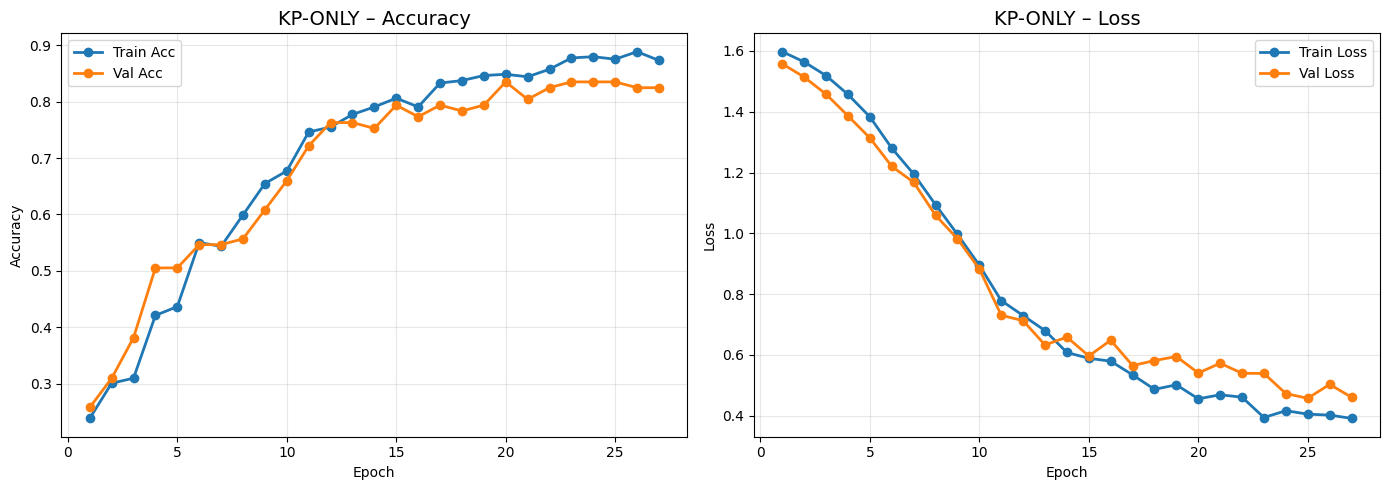

In [18]:
plot_training_curves(hist_kp, title="KP-ONLY")

In [19]:
def evaluate_kp_model(
    weights_path="kp_only_best.weights.h5",
    test_ds=None,
    name="KP-ONLY"
):
    if test_ds is None:
        test_ds = test_kp_ds  
        
    model = build_kp_model(seq_len=SEQ_LEN, num_classes=len(ACTIONS), lr=LR)
    model.load_weights(weights_path)

    loss, acc = model.evaluate(test_ds, verbose=0)
    print(f"{name} — Test acc: {acc*100:.2f}% | loss={loss:.4f}")
    
    y_true, y_pred = [], []
    for xb, yb in test_ds:
        p = model.predict(xb, verbose=0)
        y_pred.extend(np.argmax(p, axis=1))
        y_true.extend(np.argmax(yb.numpy(), axis=1))
        
    print("\n" + classification_report(
        y_true, y_pred, target_names=ACTIONS, digits=3
    ))

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(ACTIONS))))
    cm_norm = cm / cm.sum(axis=1, keepdims=True)  

    plt.figure(figsize=(7, 6))
    plt.imshow(cm_norm, cmap="Blues")

    plt.title(f"{name} — Confusion Matrix (%)", fontsize=15)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)

    plt.xticks(range(len(ACTIONS)), ACTIONS, rotation=45, ha="right")
    plt.yticks(range(len(ACTIONS)), ACTIONS)

    for i in range(len(ACTIONS)):
        for j in range(len(ACTIONS)):
            value = cm_norm[i, j]
            text = f"{value*100:.1f}"
            color = "white" if value > 0.5 else "black"
            plt.text(j, i, text, ha="center", va="center", color=color, fontsize=11)

    plt.colorbar()
    plt.tight_layout()
    plt.show()

    return acc, cm


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


KP-ONLY (12 frames) — Test acc: 86.60% | loss=0.4500

              precision    recall  f1-score   support

       CLIMB      0.765     1.000     0.867        13
        FALL      0.889     0.842     0.865        19
     LIEDOWN      0.833     0.833     0.833        12
         SIT      0.944     0.944     0.944        18
       STAND      0.875     0.800     0.836        35

    accuracy                          0.866        97
   macro avg      0.861     0.884     0.869        97
weighted avg      0.871     0.866     0.865        97



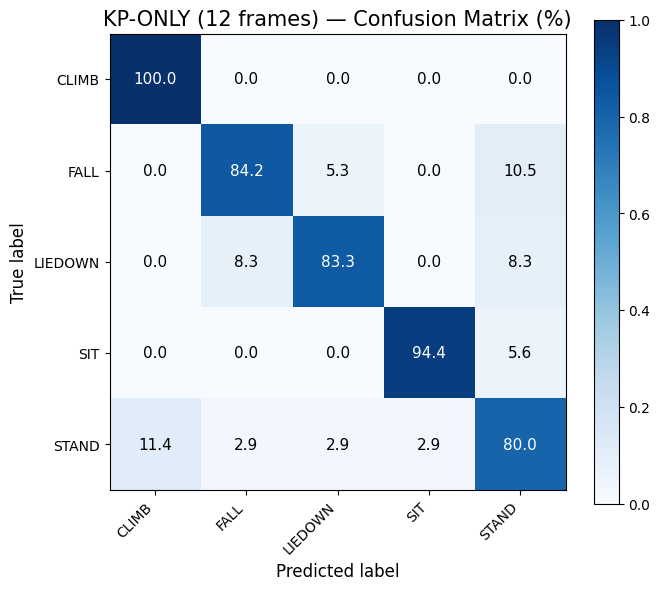


📊 Summary Test Accuracy:
   KP-ONLY : 86.60%


In [20]:
acc_kp, cm_kp = evaluate_kp_model(
    weights_path="kp_only_best.weights.h5",
    test_ds=test_kp_ds,
    name="KP-ONLY (12 frames)"
)

print("\n📊 Summary Test Accuracy:")
print(f"   KP-ONLY : {acc_kp*100:.2f}%")


In [21]:
kp_model = build_kp_model()
kp_model.load_weights("kp_only_best.weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
def collect_wrong_test_seqs(model, target_action=None, max_samples=20):
    wrong = []

    for idx, (act, img_dir, kp_dir) in enumerate(test_items):
        # nếu chỉ muốn xem ví dụ sai của 1 class cụ thể
        if (target_action is not None) and (act != target_action):
            continue

        img_paths, kp_paths = read_seq_paths(img_dir, kp_dir)
        frames, keyps = load_seq_24(
            img_paths, kp_paths,
            img_size=IMG_SIZE,
            mode="test",
            pad_mode="replicate",
            loop_tail=2,
            rng=rng_np,
        )

        if np.all(keyps == 0):
            continue

        preds = model.predict({"keypoints": keyps[np.newaxis, ...]}, verbose=0)[0]
        pred_label = ACTIONS[np.argmax(preds)]

        if pred_label != act:
            wrong.append({
                "idx": idx,
                "truth": act,
                "pred": pred_label,
                "prob": preds,
            })
            if len(wrong) >= max_samples:
                break

    print(f"🔎 Found {len(wrong)} wrong sequences"
          + (f" (class={target_action})" if target_action else ""))
    return wrong


In [23]:
wrong_fall = collect_wrong_test_seqs(kp_model, target_action="STAND", max_samples=20)
wrong_fall


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keypoints
Received: inputs=['Tensor(shape=(1, 12, 75))']
  warnings.warn(msg)


🔎 Found 7 wrong sequences (class=STAND)


[{'idx': 28,
  'truth': 'STAND',
  'pred': 'CLIMB',
  'prob': array([0.3531037 , 0.04631326, 0.3274815 , 0.08720923, 0.1858923 ],
        dtype=float32)},
 {'idx': 54,
  'truth': 'STAND',
  'pred': 'CLIMB',
  'prob': array([0.83293945, 0.01550047, 0.03808998, 0.05200974, 0.0614603 ],
        dtype=float32)},
 {'idx': 55,
  'truth': 'STAND',
  'pred': 'CLIMB',
  'prob': array([0.683595  , 0.099773  , 0.06998125, 0.03311213, 0.11353862],
        dtype=float32)},
 {'idx': 68,
  'truth': 'STAND',
  'pred': 'SIT',
  'prob': array([0.05887621, 0.03166316, 0.01605964, 0.7876213 , 0.10577969],
        dtype=float32)},
 {'idx': 82,
  'truth': 'STAND',
  'pred': 'FALL',
  'prob': array([0.008927  , 0.8777799 , 0.00829928, 0.00608995, 0.09890394],
        dtype=float32)},
 {'idx': 93,
  'truth': 'STAND',
  'pred': 'CLIMB',
  'prob': array([0.84010905, 0.00885232, 0.01150406, 0.05753607, 0.08199841],
        dtype=float32)},
 {'idx': 95,
  'truth': 'STAND',
  'pred': 'LIEDOWN',
  'prob': array([0.

Found 3 wrong sequences (class=FALL)
Truth label : FALL
Pred  label : STAND
img_dir     : /kaggle/working/data_estiomation/FALL/images_resized/fall32
kp_dir      : /kaggle/working/data_estiomation/FALL/keypoints/fall32


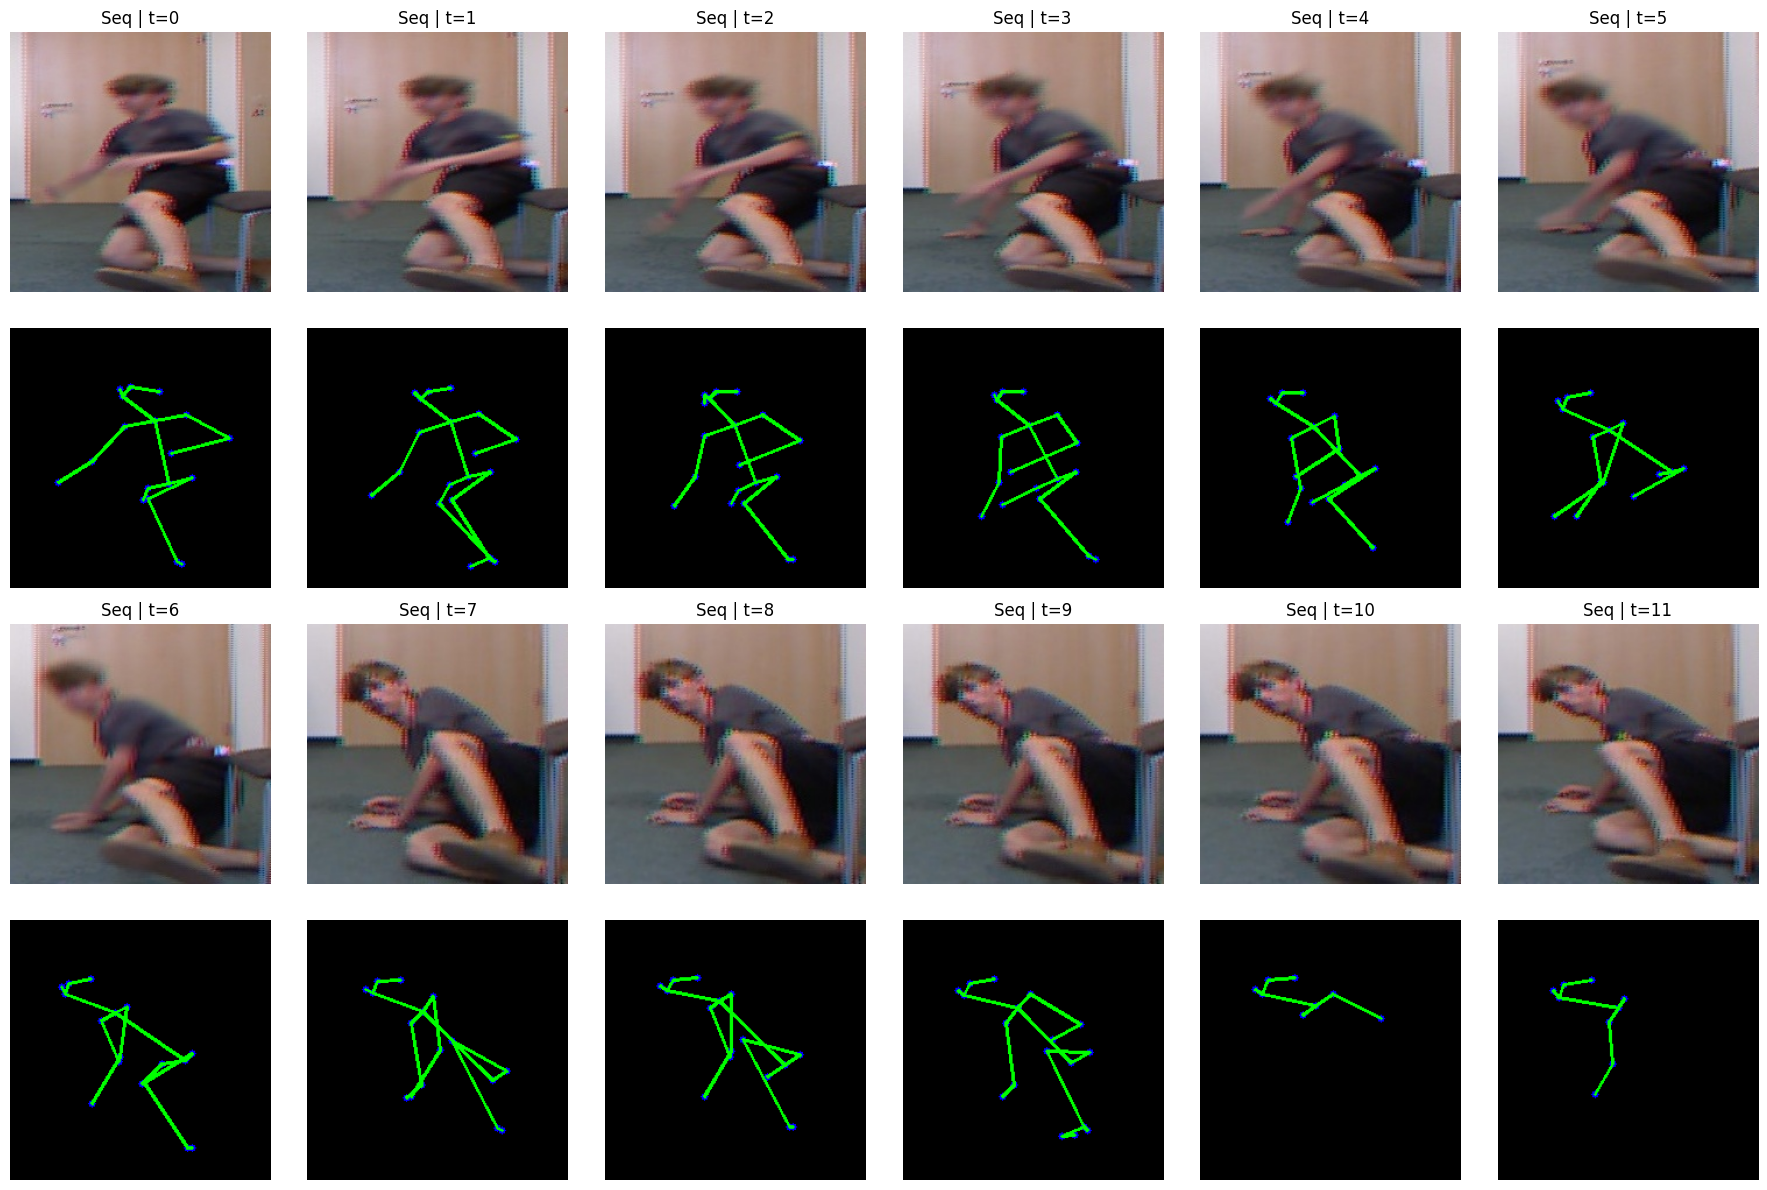

In [24]:
BODY25_EDGES = [
    (0, 1),                
    (1, 2), (2, 3), (3, 4), 
    (1, 5), (5, 6), (6, 7), 

    (1, 8),                 
    (8, 9), (9, 10), (10, 11),  

    (8, 12), (12, 13), (13, 14),

    (0, 15), (15, 17),     
    (0, 16), (16, 18),      

    (11, 22), (22, 23), (11, 24), 

    (14, 19), (19, 20), (14, 21), 
]

def collect_wrong_test_seqs(model, target_action=None, max_samples=20):
    
    wrong = []

    for idx, (act, img_dir, kp_dir) in enumerate(test_items):
        if (target_action is not None) and (act != target_action):
            continue

        img_paths, kp_paths = read_seq_paths(img_dir, kp_dir)
        frames, keyps = load_seq_24(
            img_paths, kp_paths,
            img_size=IMG_SIZE,
            mode="test",
            pad_mode="replicate",
            loop_tail=2,
            rng=rng_np,
        )

        if np.all(keyps == 0):
            continue

        preds = model.predict({"keypoints": keyps[np.newaxis, ...]}, verbose=0)[0]
        pred_label = ACTIONS[np.argmax(preds)]

        if pred_label != act:
            wrong.append({
                "idx": idx,
                "truth": act,
                "pred": pred_label,
                "prob": preds,
                "img_dir": img_dir,
                "kp_dir": kp_dir,
            })
            if len(wrong) >= max_samples:
                break

    print(f"Found {len(wrong)} wrong sequences"
          + (f" (class={target_action})" if target_action else ""))
    return wrong

def draw_skeleton_simple_on_blank(
    kp75,
    img_h,
    img_w,
    line_color=(0, 255, 0),
    point_color=(255, 0, 0),
    show_idx=False,
):
   
    canvas = np.zeros((img_h, img_w, 3), dtype=np.uint8)

    kp = kp75.reshape(25, 3).copy()
    xs = kp[:, 0] * img_w
    ys = kp[:, 1] * img_h
    cs = kp[:, 2]

  
    for idx, (x, y, c) in enumerate(zip(xs, ys, cs)):
        if c <= 0:
            continue
        px, py = int(x), int(y)
        cv2.circle(canvas, (px, py), 3, point_color, -1)
        if show_idx:
            cv2.putText(
                canvas,
                str(idx),
                (px + 4, py - 4),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,
                (0, 255, 255),
                1,
                lineType=cv2.LINE_AA,
            )

   
    for a, b in BODY25_EDGES:
        xa, ya, ca = xs[a], ys[a], cs[a]
        xb, yb, cb = xs[b], ys[b], cs[b]

        if ca <= 0 or cb <= 0:
            continue

        cv2.line(canvas, (int(xa), int(ya)), (int(xb), int(yb)), line_color, 2)

    return canvas

def visualize_seq_img_and_kp_only(frames, keyps, title="Seq", show_idx=False):
   
    T = frames.shape[0]
    H, W = frames.shape[1:3]


    if frames.dtype != np.uint8:
        if frames.max() <= 1.1:
            imgs = (frames * 255).astype(np.uint8)
        else:
            imgs = frames.astype(np.uint8)
    else:
        imgs = frames

    ncols = min(T, 6)
    nblocks = int(np.ceil(T / ncols))
    nrows = 2 * nblocks  # mỗi block: 1 hàng img + 1 hàng kp

    plt.figure(figsize=(3 * ncols, 3 * nrows))

    for i in range(T):
        block = i // ncols
        col   = i % ncols

       
        ax_img = plt.subplot(nrows, ncols, block * 2 * ncols + col + 1)
        ax_img.imshow(imgs[i])
        ax_img.axis("off")
        ax_img.set_title(f"{title} | t={i}")

     
        skel_bgr = draw_skeleton_simple_on_blank(
            keyps[i],
            img_h=H,
            img_w=W,
            show_idx=show_idx,
        )
        skel_rgb = cv2.cvtColor(skel_bgr, cv2.COLOR_BGR2RGB)

        ax_kp = plt.subplot(nrows, ncols, block * 2 * ncols + ncols + col + 1)
        ax_kp.imshow(skel_rgb)
        ax_kp.axis("off")

    plt.tight_layout()
    plt.show()


def show_wrong_example(model, wrong_list, k=0, show_idx=False):
 
    info = wrong_list[k]
    act     = info["truth"]
    pred    = info["pred"]
    img_dir = info["img_dir"]
    kp_dir  = info["kp_dir"]

    print(f"Truth label : {act}")
    print(f"Pred  label : {pred}")
    print(f"img_dir     : {img_dir}")
    print(f"kp_dir      : {kp_dir}")

    img_paths, kp_paths = read_seq_paths(img_dir, kp_dir)
    frames, keyps = load_seq_24(
        img_paths, kp_paths,
        img_size=IMG_SIZE,
        mode="test",
        pad_mode="replicate",
        loop_tail=2,
        rng=rng_np,
    )

    visualize_seq_img_and_kp_only(
        frames,
        keyps,
        show_idx=show_idx,
    )
wrong_all = collect_wrong_test_seqs(kp_model, target_action="FALL", max_samples=20)

show_wrong_example(kp_model, wrong_all, k=1, show_idx=False)


In [25]:
# # ====================================================
# # Phần có fix những keypoint lỗi - bằng cách thức suy luận
# # ====================================================

# from typing import List, Tuple, Optional, Literal
# import os, glob, json
# import numpy as np
# import cv2

# def uniform_indices(n: int, T: int = SEQ_LEN) -> List[int]:
#     """Uniform sampling T indices từ [0..n-1] (val/test)."""
#     if n <= 0:
#         return []
#     if n == T:
#         return list(range(n))
#     if n > T:
#         return [int(round(i * (n - 1) / (T - 1))) for i in range(T)]
#     return list(range(n))


# def random_window_uniform_indices(
#     n: int,
#     T: int = SEQ_LEN,
#     window_ratio: float = 0.85,
#     rng: Optional[np.random.Generator] = None
# ) -> List[int]:
#     if n <= 0:
#         return []
#     if n <= T:
#         return list(range(n))
#     if rng is None:
#         rng = np.random.default_rng()

#     W = max(T, int(round(window_ratio * n)))
#     W = min(W, n)

#     start_max = n - W
#     start = int(rng.integers(0, start_max + 1)) if start_max > 0 else 0
#     end = start + W - 1

#     return [int(round(start + i * (W - 1) / (T - 1))) for i in range(T)]

# def pad_indices(
#     n: int,
#     T: int = SEQ_LEN,
#     mode: Literal["replicate", "loop"] = "replicate",
#     loop_tail: int = 2
# ) -> List[int]:
#     """Pad index list khi n < T."""
#     idx = list(range(n))
#     if n == 0:
#         return [0] * T
#     if n >= T:
#         return idx[:T]

#     if mode == "replicate":
#         idx += [n - 1] * (T - n)
#     else:
#         tail = list(range(max(0, n - loop_tail), n)) or [n - 1]
#         while len(idx) < T:
#             idx += tail
#         idx = idx[:T]
#     return idx


# JOINT_NEIGHBORS = {
#     1: [0, 2],  2: [1, 3],  3: [2, 4],
#     5: [1, 6],  6: [5, 7],  7: [6, 8],
#     9: [8, 10], 10: [9, 11],
#     12: [11, 13], 13: [12, 14],
#     15: [0, 16], 16: [15, 17],
#     18: [17, 19], 19: [18, 20],
#     21: [0, 22], 22: [21, 23],
#     24: [23, 1],
# }

# JOINT_GROUPS = {
#     "head":      [0, 1, 15, 16, 17, 18],
#     "right_arm": [2, 3, 4],
#     "left_arm":  [5, 6, 7],
#     "spine":     [1, 8],
#     "right_leg": [9, 10, 11, 22, 23, 24],
#     "left_leg":  [12, 13, 14, 19, 20, 21],
# }


# def _invalid_mask(joints: np.ndarray) -> np.ndarray:
#     x = joints[..., 0]
#     y = joints[..., 1]
#     return ((x == 0) & (y == 0)) | np.isnan(x) | np.isnan(y)


# def clean_kps_like_realtime(kps: np.ndarray) -> np.ndarray:
  
#     if kps.size == 0:
#         return kps

#     T = kps.shape[0]
#     k3 = kps.reshape(T, 25, 3).astype(np.float32).copy()


#     for j in range(25):
#         joint = k3[:, j, :]             
#         invalid = _invalid_mask(joint)  
#         valid_idx = np.where(~invalid)[0]
#         if valid_idx.size == 0:
#             continue

#         first_valid = valid_idx[0]

#         for t in range(0, first_valid):
#             k3[t, j, :] = k3[first_valid, j, :]

#         last_valid = first_valid
#         for t in range(first_valid + 1, T):
#             if not invalid[t]:
#                 last_valid = t
#             else:
#                 k3[t, j, :] = k3[last_valid, j, :]
                
#     for t in range(T):
#         frame = k3[t]
#         invalid = _invalid_mask(frame)

    
#         for j, neighs in JOINT_NEIGHBORS.items():
#             if invalid[j]:
#                 good = [frame[n] for n in neighs if not _invalid_mask(frame[n])]
#                 if len(good) > 0:
#                     frame[j] = np.mean(good, axis=0)
#                     invalid[j] = False

#         invalid = _invalid_mask(frame)
#         for joints in JOINT_GROUPS.values():
#             g_invalid = invalid[joints]
#             if g_invalid.any() and not g_invalid.all():
#                 good = [frame[j] for j in joints if not invalid[j]]
#                 if len(good) == 0:
#                     continue
#                 mean_xyc = np.mean(good, axis=0)
#                 for j in joints:
#                     if invalid[j]:
#                         frame[j] = mean_xyc
#                         invalid[j] = False

#         k3[t] = frame

#     for t in range(1, T):
#         k3[t] = 0.4 * k3[t] + 0.6 * k3[t - 1]

#     k3 = np.nan_to_num(k3, nan=0.0)
#     return k3.reshape(T, 75)


# def read_seq_paths(img_dir: str, kp_dir: str) -> Tuple[List[str], List[str]]:
#     imgs = sorted(
#         glob.glob(os.path.join(img_dir, "*.jpg"))
#         + glob.glob(os.path.join(img_dir, "*.png"))
#     )
#     kps  = sorted(glob.glob(os.path.join(kp_dir, "*.json")))
#     n = min(len(imgs), len(kps))
#     return imgs[:n], kps[:n]


# def load_seq_24(
#     img_paths: List[str],
#     kp_paths: List[str],
#     img_size: int = IMG_SIZE,
#     mode: Literal["train", "val", "test"] = "train",
#     window_ratio: float = 0.85,
#     pad_mode: Literal["replicate", "loop"] = "replicate",
#     loop_tail: int = 2,
#     rng: Optional[np.random.Generator] = rng_np,
# ) -> Tuple[np.ndarray, np.ndarray]:
   
#     T = SEQ_LEN

#     if len(img_paths) == 0 or len(kp_paths) == 0:
#         return (np.zeros((T, img_size, img_size, 3), np.float32),
#                 np.zeros((T, 75), np.float32))

#     first = cv2.imread(img_paths[0])
#     if first is None:
#         return (np.zeros((T, img_size, img_size, 3), np.float32),
#                 np.zeros((T, 75), np.float32))

#     H, W = first.shape[:2]
#     n = min(len(img_paths), len(kp_paths))
#     img_paths = img_paths[:n]
#     kp_paths  = kp_paths[:n]

#     # chọn index
#     if n > T:
#         if mode == "train":
#             sel = random_window_uniform_indices(n, T=T, window_ratio=window_ratio, rng=rng)
#         else:
#             sel = uniform_indices(n, T=T)
#     else:
#         sel = list(range(n))

#     frames = []
#     keyps  = []

#     for i in sel:
#         im = cv2.imread(img_paths[i])
#         if im is None:
#             im = first.copy()

#         im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#         im = cv2.resize(im, (img_size, img_size))
#         frames.append(im.astype(np.float32) / 255.0)

       
#         with open(kp_paths[i], "r") as f:
#             jd = json.load(f)

#         if "people" in jd and jd["people"] and "pose_keypoints_2d" in jd["people"][0]:
#             arr = np.array(
#                 jd["people"][0]["pose_keypoints_2d"],
#                 dtype=np.float32
#             ).reshape(-1, 3)
#         else:
#             arr = np.zeros((25, 3), dtype=np.float32)

#         if W > 0 and H > 0:
#             arr[:, 0] /= float(W)
#             arr[:, 1] /= float(H)

#         keyps.append(arr.reshape(-1))

#     frames = np.stack(frames, axis=0)  
#     keyps  = np.stack(keyps,  axis=0) 
#     m = frames.shape[0]

  
#     if m < T:
#         pidx = pad_indices(m, T, mode=pad_mode, loop_tail=loop_tail)
#         frames = frames[pidx[:T]]
#         keyps  = keyps[pidx[:T]]

#     keyps = clean_kps_like_realtime(keyps)

 
#     frames = frames[:T]
#     keyps  = keyps[:T]

#     return frames.astype(np.float32), keyps.astype(np.float32)


# print("Sampling, padding & realtime-style KP cleaning ready.")
